In [1]:
import casadi
import numpy as np
from utils.Lagrange import *
from utils.LGL_collocation import LGL_collocation
from utils.LocalChart import *
import pinocchio as pin
from pinocchio import casadi as cpin
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import scipy

In [2]:
Ntp = 50   # Number of collocation points / basis each phase (degree: Ntp-1)

In [3]:
ngc = 5
nhc = 3
ndof = ngc-nhc

Lbase = 0.12
Ldistal = 0.15
Lproximal = 0.2
mdistal = 0.8925
mproximal = 1.2093

Loffset = np.array([0, Lproximal, Ldistal, Ldistal, Lproximal])

mass = np.array([mproximal, mdistal, mdistal, mproximal])
Lcm = np.array([0.11, 0.0746, Ldistal-0.0746, Lproximal-0.11])
Iz = np.array([7, 2.3, 2.3, 7])*1e-3

inertia = [None]*ngc
for i in range(ngc-1):
    inertia[i] = pin.Inertia(mass[i], np.array([Lcm[i], 0.0, 0.0]), np.diag([0, Iz[i], Iz[i]])) # mass, com, inertia


FourBar = pin.Model()
joint_id = 0  # Root

for i in range(ngc):
    joint_type = pin.JointModelRY()    # Define joint type (Revolute joint around Y-axis)
    '''Add joint to the model'''
    # joint_index = model.addJoint(parent_frame, joint_type, child_frame, joint name)
    joint_id = FourBar.addJoint(joint_id, joint_type, pin.SE3(np.eye(3), np.array([Loffset[i],0,0])), f'joint {i+1}')
    '''Append body to the joint'''
    # body_id = model.appendBodyToJoint(joint_id, inertia, joint_placement)
    if i < ngc-1:
        body_id = FourBar.appendBodyToJoint(joint_id, inertia[i], pin.SE3.Identity())

data = FourBar.createData()

In [4]:
q = casadi.SX.sym("q", ngc, 1)
dq = casadi.SX.sym("dq", ngc, 1)

# kinematic loop
q1_ = q[0]
q2_ = q1_+q[1]
q3_ = q2_+q[2]
q4_ = q3_+q[3]
q5_ = q4_+q[4]

F_q = [ Lproximal*np.cos(q1_) + Ldistal*np.cos(q2_) + Ldistal*np.cos(q3_) + Lproximal*np.cos(q4_) + Lbase,
        Lproximal*np.sin(q1_) + Ldistal*np.sin(q2_) + Ldistal*np.sin(q3_) + Lproximal*np.sin(q4_),
        np.sin(q5_) ]
Fq = casadi.vertcat(*F_q)
Jq = casadi.jacobian(Fq, q)
# J(q) @ ddq = x(q,dq) = -dJ(q)/dt @ dq
dJq_dt = casadi.jtimes(Jq, q, dq)   # shape = (nhc, ngc)
F_holonomic = casadi.Function("F_holonomic", [q], [Fq])
J_holonomic = casadi.Function("J_holonomic", [q], [Jq])

print(J_holonomic)

J_holonomic:(i0[5])->(o0[3x5,13nz]) SXFunction


In [5]:
# open-chain dynamics
cmodel = cpin.Model(FourBar)
cdata = cmodel.createData()

# Mass matrix
M = cpin.crba(cmodel, cdata, q)
# Coriolis
C = cpin.computeCoriolisMatrix(cmodel, cdata, q, dq)
# Gravity
G = cpin.computeGeneralizedGravity(cmodel, cdata, q)

ConstrDyn = casadi.vertcat(casadi.horzcat(M, Jq.T), casadi.horzcat(Jq, casadi.DM.zeros(nhc, nhc)))

u = casadi.SX.sym("u", ndof, 1)             # control input
uc = casadi.vertcat(*[u[0],0,0,0,u[-1]])    # number of active joints = ndof
Tau = uc - C @ dq - G  

'''
un = casadi.SX.sym("un", ngc, 1)
F_Acc = casadi.Function(
    "F_Acc",
    [q, dq, un],
    [casadi.vertcat(dq,
                    cpin.aba(cmodel, cdata, q, dq, un))]
)
'''

F_ConstrAcc = casadi.Function(
    "ConstrAcc", 
    [q, dq, u], 
    [
        casadi.vertcat(dq, 
                       casadi.horzcat(np.eye(ngc), np.zeros((ngc, nhc))) @ casadi.inv(ConstrDyn) @ casadi.vertcat(Tau, -dJq_dt@dq))
    ]
)

print(F_ConstrAcc)

ConstrAcc:(i0[5],i1[5],i2[2])->(o0[10]) SXFunction


### Local Parameterization (Tangent Chart)

In [6]:
LOCALCHART = LocalChart(ngc, nhc, ndof, J_holonomic)
q_manifold_to_local, dq_manifold_to_local, dq_local_to_manifold, ddq_local_to_manifold = LOCALCHART.getFuncs()
F_LocalAcc = LOCALCHART.F_LocalAcc(F_ConstrAcc)

### Gauss–Legendre Collocation

In [7]:
LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp)
DL,_ = differentiation_matrix(Ntp, LGL_Pts)

LGL = LGL_collocation(Ntp, ngc, ndof)
StatesDiff, StateDiff, LocalsDiff, LocalDiff= LGL.getDiffFuncs()

### Initialization

In [8]:
lowerPositionLimit = -2*np.pi * np.ones((ngc))  # rad
upperPositionLimit = 2*np.pi * np.ones((ngc))   # rad
lowerVelocityLimit = -np.pi/2 * np.ones((ngc))  # rad/s
upperVelocityLimit = np.pi/2 * np.ones((ngc))
lowerTorqueLimit  = -5 * np.ones((ndof))
upperTorqueLimit  = 5 * np.ones((ndof))

q_waypoints = np.array([[1.3919,0.7860,1.9008,0.7278,1.4766], 
                        [2.0851,-0.6221,3.5712,-0.7617,2.0107],
                        [2.6021,-0.5985,4.0018,-1.4423,1.7201]])

Np = q_waypoints.shape[0]-1       # Number of phase (dersired waypoints: N+1)
T = Np*Ntp   # Number of total collocation points / optimization variables

#### Initial Guesses

In [9]:
t_initial = 2
ini_collo_pts = t_initial/2 * (LGL_Pts+1)

ini_p = np.full((Ntp, ndof), 0.0)
ini_q = np.full((Ntp, ngc), 0.0)
y_waypoints = [None]* (Np+1)
ini_x = [None] * T
ini_y = [None] * T
ini_u = [None] * T

q0_basis_list = [None] * Np

for k in range(Np):
    for j in range(Ntp):

        q0_ = q_waypoints[k]
        qT_ = q_waypoints[k+1]
        q0_basis = local_basis(q0_, J_holonomic)   # basis of tangent space at q0_
        q0_basis_list[k] = q0_basis

        y_waypoints[k] = q_manifold_to_local(q0_, q0_, q0_basis)
        y_waypoints[k+1] = q_manifold_to_local(qT_, q0_, q0_basis)

        ini_p[j,:] = np.squeeze(y_waypoints[k] + ini_collo_pts[j]/t_initial*(y_waypoints[k+1]-y_waypoints[k]))
        ini_q[j,:] = q_local_to_manifold(q0_, q0_basis, ini_p[j,:], F_holonomic)

    ini_dp = np.array([np.squeeze(LocalDiff(casadi.vertcat(*ini_p), t_initial, DL[i,:])) for i in range(Ntp)])
    ini_ddp = np.array([np.squeeze(LocalDiff(casadi.vertcat(*ini_dp), t_initial, DL[i,:])) for i in range(Ntp)])
    ini_dq = np.array([np.squeeze(dq_local_to_manifold(ini_dp[i,:], ini_q[i,:], q0_basis)) for i in range(Ntp)])
    ini_ddq = np.array([np.squeeze(ddq_local_to_manifold(ini_dp[i,:], ini_ddp[i,:], ini_q[i,:], ini_dq[i,:], q0_basis)) for i in range(Ntp)])
    ini_dyn = np.array([pin.rnea(FourBar, data, ini_q[i], ini_dq[i], ini_ddq[i]) for i in range(Ntp)])  # M@ddq + C@dq + G

    # Lagrange multiplier of constraint force
    multiplier = np.array([np.linalg.inv(J_holonomic(ini_q[i]).T[1:4,:]) @ -ini_dyn[i,1:4] for i in range(Ntp)])
    ini_U = np.array([np.squeeze(ini_dyn[i] + J_holonomic(ini_q[i]).T @ multiplier[i]) for i in range(Ntp)])

    for j in range(Ntp):
        t = k*Ntp + j
        ini_x[t] =  np.concatenate([ini_q[j],ini_dq[j]])
        ini_y[t] = np.concatenate([ini_p[j],ini_dp[j]])
        ini_u[t] = np.array([ini_U[j][0],ini_U[j][-1]])

print(y_waypoints)
print(ini_u)

[DM([0, 0]), DM([0, 0]), DM([0.97005, -0.0481143])]
[array([-1.16032013, -0.90533559]), array([-1.15599666, -0.90145092]), array([-1.14584668, -0.89233339]), array([-1.12995076, -0.87806074]), array([-1.1083848 , -0.85870926]), array([-1.08124901, -0.83437926]), array([-1.04866737, -0.805194  ]), array([-1.01078612, -0.77129755]), array([-0.96777235, -0.73285267]), array([-0.9198126 , -0.69003858]), array([-0.86711179, -0.64304896]), array([-0.80989248, -0.59209014]), array([-0.74839447, -0.5373795 ]), array([-0.68287472, -0.47914405]), array([-0.61360771, -0.41761912]), array([-0.54088598, -0.35304701]), array([-0.46502105, -0.28567538]), array([-0.38634467, -0.21575521]), array([-0.30521041, -0.14353796]), array([-0.22199602, -0.06927141]), array([-0.13710688,  0.00680651]), array([-0.05098148,  0.08447709]), array([0.03589937, 0.1635556 ]), array([0.12299654, 0.2439153 ]), array([0.20968362, 0.32552842]), array([0.29519176, 0.40854044]), array([0.37849857, 0.49341522]), array([0.458

In [10]:
# Verify kinematic constraint of initial guess
j = 6
print(f" Should be zero: {J_holonomic(ini_q[j]) @ ini_dq[j]}")
xi = casadi.Function("xi", [q,dq], [-dJq_dt@dq])
print(f" Should be equal: {J_holonomic(ini_q[j]) @ ini_ddq[j]} == {xi(ini_q[j], ini_dq[j])} ")

# Verify constrained dynamics of initial guess
print(f" Should be equal: {ini_ddq[j]} == {F_ConstrAcc(ini_q[j], ini_dq[j], ini_u[k*Ntp + j])[ngc:]} ")

print(f" Should be equal: {q0_basis_list[k].T[nhc:,:] @ ini_ddq[j]} == {LocalDiff(casadi.vertcat(*ini_dp), t_initial, DL[j,:])} ")


#print(F_LocalAcc(ini_q[j], ini_dq[j], ini_u[k*Ntp + j], q0_basis_list[k]))  # q0_basis.T[nhc:,:] @ F_ConstrAcc(q, dq, u)

 Should be zero: [0, 6.93889e-18, -4.16334e-17]
 Should be equal: [0.00636985, -0.0115623, 0] == [0.00636985, -0.0115623, 1.71057e-49] 
 Should be equal: [ 0.06456188 -0.03411386  0.01057762  0.0488022  -0.08982784] == [0.0645619, -0.0341139, 0.0105776, 0.0488022, -0.0898278] 
 Should be equal: [-2.41846e-13, 1.15255e-14] == [-2.41966e-13, 1.15658e-14] 


### Nonlinear Optimization Problem (NLP)

In [11]:
opti = casadi.Opti()
# Optimization variables
var_xs = [opti.variable(2*ngc) for _ in range(T)]
var_ys = [opti.variable(2*ndof) for _ in range(T)]
var_us = [opti.variable(ndof) for _ in range(T)]
var_deltaT = [opti.variable(1) for _ in range(Np)]

for i in range(Np):
    opti.subject_to(var_deltaT[i] > 0.0)

    for tp in range(Ntp):
        t = i*Ntp + tp

        # constriants   solve x = H^(-1)(y) <-> y = H(x) and F(x) = 0
        opti.subject_to(F_holonomic(var_xs[t][:ngc]) == 0)
        opti.subject_to(q_manifold_to_local(var_xs[t][:ngc], q_waypoints[i], q0_basis_list[i]) == var_ys[t][:ndof])

        opti.subject_to(J_holonomic(var_xs[t][:ngc]) @ var_xs[t][ngc:] == 0)
        opti.subject_to(dq_manifold_to_local(var_xs[t][ngc:], q0_basis_list[i]) == var_ys[t][ndof:])

        #dynamics
        opti.subject_to(LocalsDiff(casadi.vertcat(*var_ys[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[tp,:]) 
                        == F_LocalAcc(var_xs[t][:ngc], var_xs[t][ngc:], var_us[t], q0_basis_list[i]))
        
        # joint constraints
        opti.subject_to(var_xs[t][:ngc] <= upperPositionLimit)
        opti.subject_to(var_xs[t][:ngc] >= lowerPositionLimit)
        # joint velocity constraints
        opti.subject_to(var_xs[t][ngc:] <= upperVelocityLimit)
        opti.subject_to(var_xs[t][ngc:] >= lowerVelocityLimit)
        # torque constraints
        opti.subject_to(var_us[t] <= upperTorqueLimit)
        opti.subject_to(var_us[t] >= lowerTorqueLimit)

# waypoint constraints
for i in range(1, Np):
    opti.subject_to(var_ys[i*Ntp][:ndof] == y_waypoints[i])

# continuity constraints
for i in range(1, Np):
    opti.subject_to(var_xs[i*Ntp-1] == var_xs[i*Ntp])
    opti.subject_to(var_us[i*Ntp-1] == var_us[i*Ntp])

# boundary conditions
opti.subject_to(var_ys[0] == ini_y[0])
opti.subject_to(var_ys[-1] == ini_y[-1])

#Objective
total_cost = 0
for i in range(Np):
    for tp in range(Ntp):
        total_cost += var_deltaT[i]/2 * LGL_Wts[tp] * var_us[i*Ntp+tp].T @ var_us[i*Ntp+tp]
    total_cost += var_deltaT[i]

opti.minimize(total_cost)
opti.solver("ipopt")

In [12]:
for t in var_deltaT:
    opti.set_initial(t, t_initial)
for t in range(T):
    opti.set_initial(var_xs[t], ini_x[t])
    opti.set_initial(var_ys[t], ini_y[t])
    opti.set_initial(var_us[t], ini_u[t])

In [13]:
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_ys = [opti.value(var_y) for var_y in var_ys]
    sol_us = [opti.value(var_u) for var_u in var_us]
    sol_T = [opti.value(var_t) for var_t in var_deltaT]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:    30134
Number of nonzeros in inequality constraint Jacobian.:     2402
Number of nonzeros in Lagrangian Hessian.............:     7302

Total number of variables............................:     1602
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1422
Total number of inequality c

In [14]:
print(sol_T)
print(f"Total time: {sum(sol_T)}")

T_List = [0] + [sum(sol_T[:i+1]) for i in range(Np)]

# verify kinematic loop
sol_F = [F_holonomic(var_x[:ngc]) for var_x in sol_xs]
print(sol_F)

[1.0803131496638454, 0.45644609838617867]
Total time: 1.536759248050024
[DM([-4.16334e-17, 2.77556e-17, -2.44929e-16]), DM([-2.77556e-16, 5.55112e-17, -2.44929e-16]), DM([8.32667e-17, -2.77556e-17, 6.43249e-16]), DM([1.52656e-16, -2.77556e-17, 6.43249e-16]), DM([1.11022e-16, 0, 6.43249e-16]), DM([1.80411e-16, 2.77556e-17, 6.43249e-16]), DM([2.77556e-16, 2.77556e-17, 1.53143e-15]), DM([1.11022e-16, 2.77556e-17, 6.43249e-16]), DM([0, 2.77556e-17, -2.44929e-16]), DM([1.94289e-16, -2.77556e-17, 6.43249e-16]), DM([-1.38778e-16, -2.77556e-17, -2.44929e-16]), DM([-1.38778e-16, 5.55112e-17, -2.44929e-16]), DM([-2.77556e-17, -1.38778e-16, -2.44929e-16]), DM([0, 2.77556e-17, -2.44929e-16]), DM([2.35922e-16, -2.77556e-17, 6.43249e-16]), DM([-1.11022e-16, 5.55112e-17, -2.44929e-16]), DM([3.05311e-16, -5.55112e-17, 6.43249e-16]), DM([-2.91434e-16, -2.77556e-17, -1.13311e-15]), DM([2.35922e-16, 0, -2.44929e-16]), DM([-2.08167e-16, -1.11022e-16, -2.44929e-16]), DM([2.77556e-17, 1.11022e-16, 6.43249e-

### Inverse dynamics

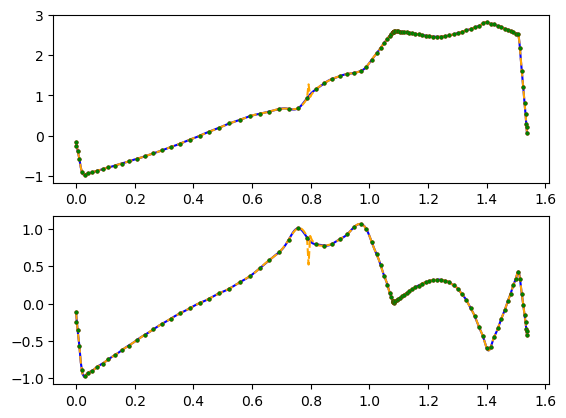

In [15]:
nsample = 200
fig, axs = plt.subplots(ndof,1)
for i in range(Np):
    sample_t = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]
    t = casadi.SX.sym("t")

    inter_ys = casadi.Function(
        "yt", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_ys[i*Ntp: (i+1)*Ntp])]
    )
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )
    inter_dys = casadi.Function(
        "dyt", 
        [t], [DiffLangrangeInterpolation(t, collo_pts, sol_ys[i*Ntp: (i+1)*Ntp])]
    )

    sample_p = np.array([np.squeeze(inter_ys(t))[:ndof] for t in sample_t])
    sample_dp = np.array([np.squeeze(inter_ys(t))[ndof:] for t in sample_t])
    sample_ddp = np.array([np.squeeze(inter_dys(t))[ndof:] for t in sample_t])

    # Interpolated control input
    sample_u = np.array([np.squeeze(inter_us(t)) for t in sample_t])

    # Inverse dynamics from interpolated trajectory
    sample_q = np.array([q_local_to_manifold(q_waypoints[i], q0_basis_list[i], sample_p[k,:], F_holonomic) for k in range(nsample)])
    sample_dq = np.array([np.squeeze(dq_local_to_manifold(sample_dp[k,:], sample_q[k,:], q0_basis_list[i])) for k in range(nsample)])
    sample_ddq = np.array([np.squeeze(ddq_local_to_manifold(sample_dp[k,:], sample_ddp[k,:], sample_q[k,:], sample_dq[k,:], q0_basis_list[i])) for k in range(nsample)])
    sample_U = np.zeros((nsample, ndof))
    for k in range(nsample):
        dyn_i = pin.rnea(FourBar, data, sample_q[k], sample_dq[k], sample_ddq[k])
        multiplier_i = np.linalg.inv(J_holonomic(sample_q[k]).T[1:4,:]) @ -dyn_i[1:4]
        temp = np.squeeze(dyn_i + J_holonomic(sample_q[k]).T @ multiplier_i)
        sample_U[k,0] = temp[0]
        sample_U[k,-1] = temp[-1]

    # Inverse dynamics at collocation points
    collo_u = np.zeros((Ntp, ngc))
    for j in range(Ntp):
        t = i*Ntp + j
        collo_ddq = np.squeeze(ddq_local_to_manifold(sol_ys[t][ndof:], inter_dys(collo_pts[j])[ndof:], sol_xs[t][:ngc], sol_xs[t][ngc:], q0_basis_list[i]))
        collo_dyn = pin.rnea(FourBar, data, sol_xs[t][:ngc], sol_xs[t][ngc:], collo_ddq)
        collo_multiplier = np.linalg.inv(J_holonomic(sol_xs[t][:ngc]).T[1:4,:]) @ -collo_dyn[1:4]
        collo_u[j,:] = np.squeeze(collo_dyn + J_holonomic(sol_xs[t][:ngc]).T @ collo_multiplier)

    for k in range(ndof):
        axs[k].plot(sample_t, sample_u[:,k], label=f'u{k}',color='blue')
        if k == 0:
            axs[k].plot(sample_t, sample_U[:,0], label=f'tau{k}',color='orange',linestyle='dashed')
            for j, col in enumerate(collo_pts):
                t = i*Ntp + j
                axs[k].plot(col, sol_us[t][0], color='red', marker='o', markersize=2)
                axs[k].plot(col, collo_u[j,0], color='green', marker='o', markersize=2)
        else:
            axs[k].plot(sample_t, sample_U[:,-1], label=f'tau{i}',color='orange',linestyle='dashed') 
            for j, col in enumerate(collo_pts):
                t = i*Ntp + j
                axs[k].plot(col, sol_us[t][-1], color='red', marker='o',markersize=2)
                axs[k].plot(col, collo_u[j,-1], color='green', marker='o',markersize=2)

plt.show()

In [16]:
"""
# plot trajectories local coordinates
fig, axs = plt.subplots(3,1)

axs[0].plot(sample_t, sample_p[:,0], label=f'p{i}') # blue
axs[0].plot(sample_t, sample_p[:,1], label=f'dp{i}') # orange
    #axs[i].plot(sample_t, sample_dp[:,i], label=f'dp{i}')

axs[1].plot(sample_t, sample_dp[:,0], label=f'dp{i}')
axs[1].plot(sample_t, sample_dp[:,1], label=f'dp{i}')

axs[2].plot(sample_t, sample_ddp[:,0], label=f'ddp{i}')
axs[2].plot(sample_t, sample_ddp[:,1], label=f'ddp{i}')
plt.show()
"""

"\n# plot trajectories local coordinates\nfig, axs = plt.subplots(3,1)\n\naxs[0].plot(sample_t, sample_p[:,0], label=f'p{i}') # blue\naxs[0].plot(sample_t, sample_p[:,1], label=f'dp{i}') # orange\n    #axs[i].plot(sample_t, sample_dp[:,i], label=f'dp{i}')\n\naxs[1].plot(sample_t, sample_dp[:,0], label=f'dp{i}')\naxs[1].plot(sample_t, sample_dp[:,1], label=f'dp{i}')\n\naxs[2].plot(sample_t, sample_ddp[:,0], label=f'ddp{i}')\naxs[2].plot(sample_t, sample_ddp[:,1], label=f'ddp{i}')\nplt.show()\n"

In [17]:
"""
# plot trajectories joint variables
fig, axs = plt.subplots(3,1)

for i in range(ngc):
    axs[0].plot(sample_t, sample_q[:,i], label=f'q{i}')

for i in range(ngc):
    axs[1].plot(sample_t, sample_dq[:,i], label=f'dq{i}')

for i in range(ngc):
    axs[2].plot(sample_t, sample_ddq[:,i], label=f'ddq{i}')

plt.show()
"""

"\n# plot trajectories joint variables\nfig, axs = plt.subplots(3,1)\n\nfor i in range(ngc):\n    axs[0].plot(sample_t, sample_q[:,i], label=f'q{i}')\n\nfor i in range(ngc):\n    axs[1].plot(sample_t, sample_dq[:,i], label=f'dq{i}')\n\nfor i in range(ngc):\n    axs[2].plot(sample_t, sample_ddq[:,i], label=f'ddq{i}')\n\nplt.show()\n"

### Forward Dynamics

In [18]:
def ForwardDynamics(y, t, q0, q0_basis, inter_us):  # local coordinates
    q = q_local_to_manifold(q0, q0_basis, y[:ndof], F_holonomic)
    dq = dq_local_to_manifold(y[ndof:], q, q0_basis)
    u = inter_us(t)
    dy = np.squeeze(np.array([F_LocalAcc(q, dq, u, q0_basis)]))
    return dy


y_forward = [None]*Np
for i in range(Np):
    time_grid = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]
    t = casadi.SX.sym("t")
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )
    y0 = sol_ys[i*Ntp]   # initial condition
    y_forward[i] = scipy.integrate.odeint(ForwardDynamics, y0, time_grid, args = (q_waypoints[i], q0_basis_list[i], inter_us))

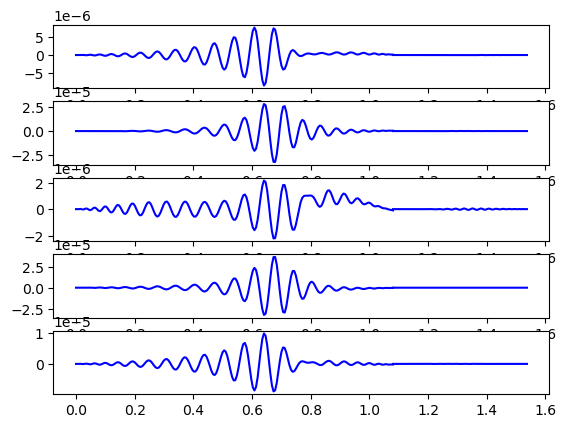

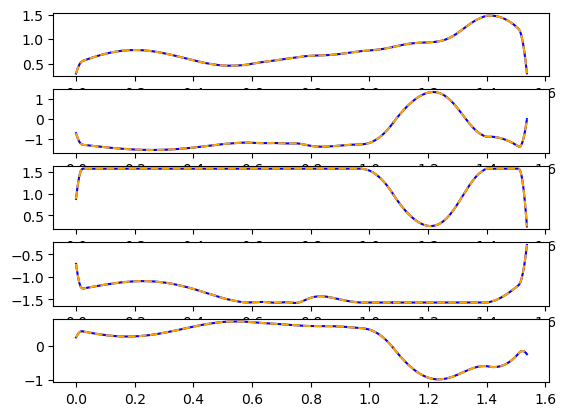

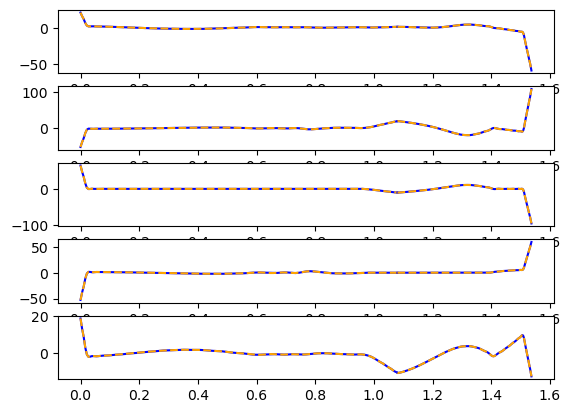

In [19]:
fig1, axs1 = plt.subplots(ngc, 1)  # joint positions
fig2, axs2 = plt.subplots(ngc, 1)  # joint velocities
fig3, axs3 = plt.subplots(ngc, 1)  # joint accelerations


for i in range(Np):
    time_grid = np.linspace(T_List[i], T_List[i+1], nsample)
    collo_pts = sol_T[i]/2 * (LGL_Pts+1) + T_List[i]

    inter_ys = casadi.Function(
        "yt", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_ys[i*Ntp: (i+1)*Ntp])]
    )
    inter_us = casadi.Function(
        "ut", 
        [t], [LagrangeInterpolation(t, collo_pts, sol_us[i*Ntp: (i+1)*Ntp])]
    )

    inter_dys = casadi.Function(
        "dyt", 
        [t], [DiffLangrangeInterpolation(t, collo_pts, sol_ys[i*Ntp: (i+1)*Ntp])]
    )

    q_forward = np.array([q_local_to_manifold(q_waypoints[i], q0_basis_list[i], y_forward[i][k,:ndof], F_holonomic) for k in range(nsample)])
    dq_forward = np.array([np.squeeze(dq_local_to_manifold(y_forward[i][k,ndof:], q_forward[k,:], q0_basis_list[i])) for k in range(nsample)])
    ddq_forward = np.array([np.squeeze(ddq_local_to_manifold(y_forward[i][k,ndof:], 
                                                            F_LocalAcc(q_forward[k,:], dq_forward[k,:], inter_us(time_grid[k]), q0_basis_list[i])[ndof:], 
                                                            q_forward[k,:], dq_forward[k,:], q0_basis_list[i])) 
                                                            for k in range(nsample)])

    sample_p = np.array([np.squeeze(inter_ys(t))[:ndof] for t in time_grid])
    sample_dp = np.array([np.squeeze(inter_ys(t))[ndof:] for t in time_grid])
    sample_ddp = np.array([np.squeeze(inter_dys(t))[ndof:] for t in time_grid])

    # Interpolated trajectory
    sample_q = np.array([q_local_to_manifold(q_waypoints[i], q0_basis_list[i], sample_p[k,:], F_holonomic) for k in range(nsample)])
    sample_dq = np.array([np.squeeze(dq_local_to_manifold(sample_dp[k,:], sample_q[k,:], q0_basis_list[i])) for k in range(nsample)])
    sample_ddq = np.array([np.squeeze(ddq_local_to_manifold(sample_dp[k,:], sample_ddp[k,:], sample_q[k,:], sample_dq[k,:], q0_basis_list[i])) for k in range(nsample)])

    for j in range(ngc):
        axs1[j].plot(time_grid, q_forward[:,j]-sample_q[:,j], label=f'Integrate_q{j}',color='blue')

    for j in range(ngc):
        axs2[j].plot(time_grid, dq_forward[:,j], label=f'Integrate_dq{j}',color='blue')
        axs2[j].plot(time_grid, sample_dq[:,j], label=f'Nominal_dq{j}',color='orange',linestyle='dashed')

    for j in range(ngc):
        axs3[j].plot(time_grid, ddq_forward[:,j], label=f'Integrate_ddq{j}',color='blue')   # blue
        axs3[j].plot(time_grid, sample_ddq[:,j], label=f'Nominal_ddq{j}', color='orange',linestyle='dashed')      # orange

plt.show()